In [1]:
import pandas as pd
import re
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
from collections import defaultdict
import numpy as np
import pytz
import re

In [2]:

# Read the list of filenames from the configuration file
with open('file_list.txt', 'r', encoding='utf-8') as config_file:
    file_names = config_file.read().splitlines()

# Regex pattern to match the data format
pattern = r'\[(.*?)\] (.*?): (.*)'

# Initialize an empty list to store parsed data
datalist = []
stream_count = 0
# Iterate over each specified file
for file in file_names:
    full_path = "data\\"+file
    with open(full_path, 'r', encoding='utf-8') as f:
        lines = f.readlines()
        for line in lines:
            match = re.match(pattern, line)
            if match:
                date, user, message = match.groups()
                datalist.append([date, user, message,stream_count])
    stream_count = stream_count + 1

# Create a DataFrame from the parsed data
data = pd.DataFrame(datalist, columns=["date", "user", "message","stream"])

In [3]:
data['date'] = pd.to_datetime(data['date'])

In [4]:
def convert_utc_to_cet(df, date_column='date'):
    
    # Make a copy to avoid modifying the original
    df = df.copy()
    
    # Ensure timestamps are UTC aware
    if df[date_column].dt.tz is None:
        df[date_column] = df[date_column].dt.tz_localize('UTC')
    elif df[date_column].dt.tz != pytz.UTC:
        df[date_column] = df[date_column].dt.tz_convert('UTC')
    
    # Convert to CET/CEST (Europe/Berlin includes proper DST handling)
    df[date_column] = df[date_column].dt.tz_convert('Europe/Berlin')
    
    return df


In [5]:
data = convert_utc_to_cet(data)

In [6]:
data["user"] = data["user"].replace("Banties1g", "banties_x")
data["user"] = data["user"].replace("banties1g", "banties_x")
data["user"] = data["user"].replace("chili_poe", "chili_con_bacon")
data["user"] = data["user"].replace("CHILI_POE", "chili_con_bacon")
data["user"] = data["user"].replace("chili_conbacon", "chili_con_bacon")
data["user"] = data["user"].replace("Wirelesss_", "W1r3lesss")
data["user"] = data["user"].replace("treklul", "trek44_")
data["user"] = data["user"].replace("ttrek_", "trek44_")
data["user"] = data["user"].replace("trek_x", "trek44_")
data["user"] = data["user"].replace("TriplesingleJ", "TripleSingleJames")
data["user"] = data["user"].replace("uuccugr", "uwu_cougar")
data["user"] = data["user"].replace("uuccugr", "uuccugr_")
data["user"] = data["user"].replace("StanIV4_", "stan_iv4")

In [7]:
# Get all unique usernames
unique_users = data['user'].unique()

# Create a mapping from lowercase username to all variants

user_variants = defaultdict(set)
for user in unique_users:
    user_variants[user.lower()].add(user)

# Find usernames with different capitalization
duplicate_users = {k: v for k, v in user_variants.items() if len(v) > 1}

In [8]:
# Create a mapping from all variants to the canonical (sorted first) variant
variant_map = {}
for variants in duplicate_users.values():
    sorted_variants = sorted(variants)
    canonical = sorted_variants[0]
    for v in variants:
        variant_map[v] = canonical

# Replace usernames in 'user' column
data['user'] = data['user'].apply(lambda u: variant_map.get(u, u))

🚀 Starting Chatlog Analysis...
✅ Data loaded: 2580816 messages from 82655 unique users
📅 Date range: 2024-05-01 17:04:02+02:00 to 2025-10-10 19:55:18+02:00
🎮 Total streams: 442

🔍 Analyzing chatter categories...
✅ Analysis complete: 278 streams analyzed from Nov 15, 2024

📈 Summary Statistics:
------------------------------
Total New Chatters: 69842
Total Casual Chatters: 122834
Total Regular Chatters: 31822
Average per stream: 807.5 unique chatters

🎨 Creating visualizations...
📈 Creating line chart...


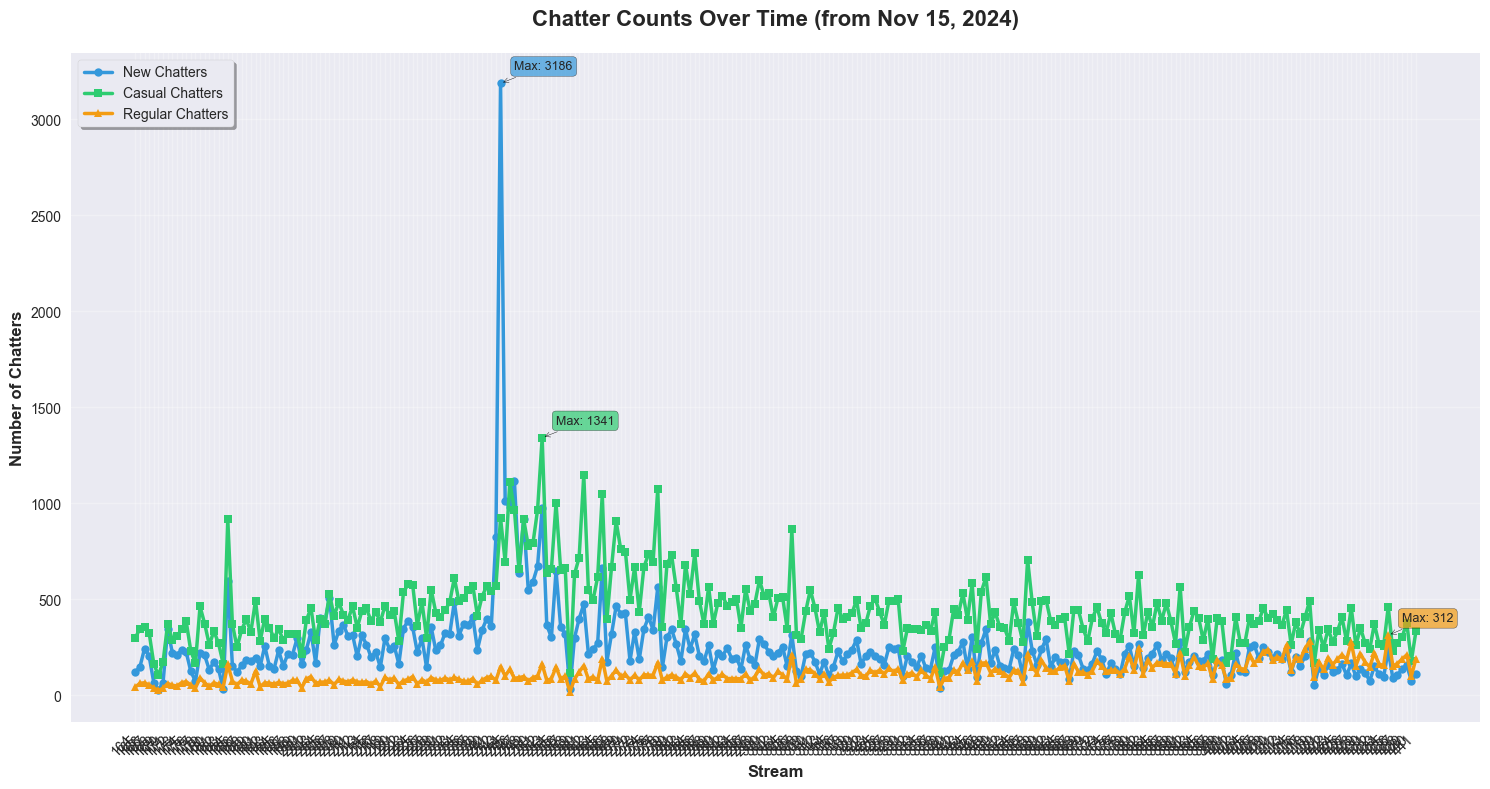

📊 Creating stacked bar chart...


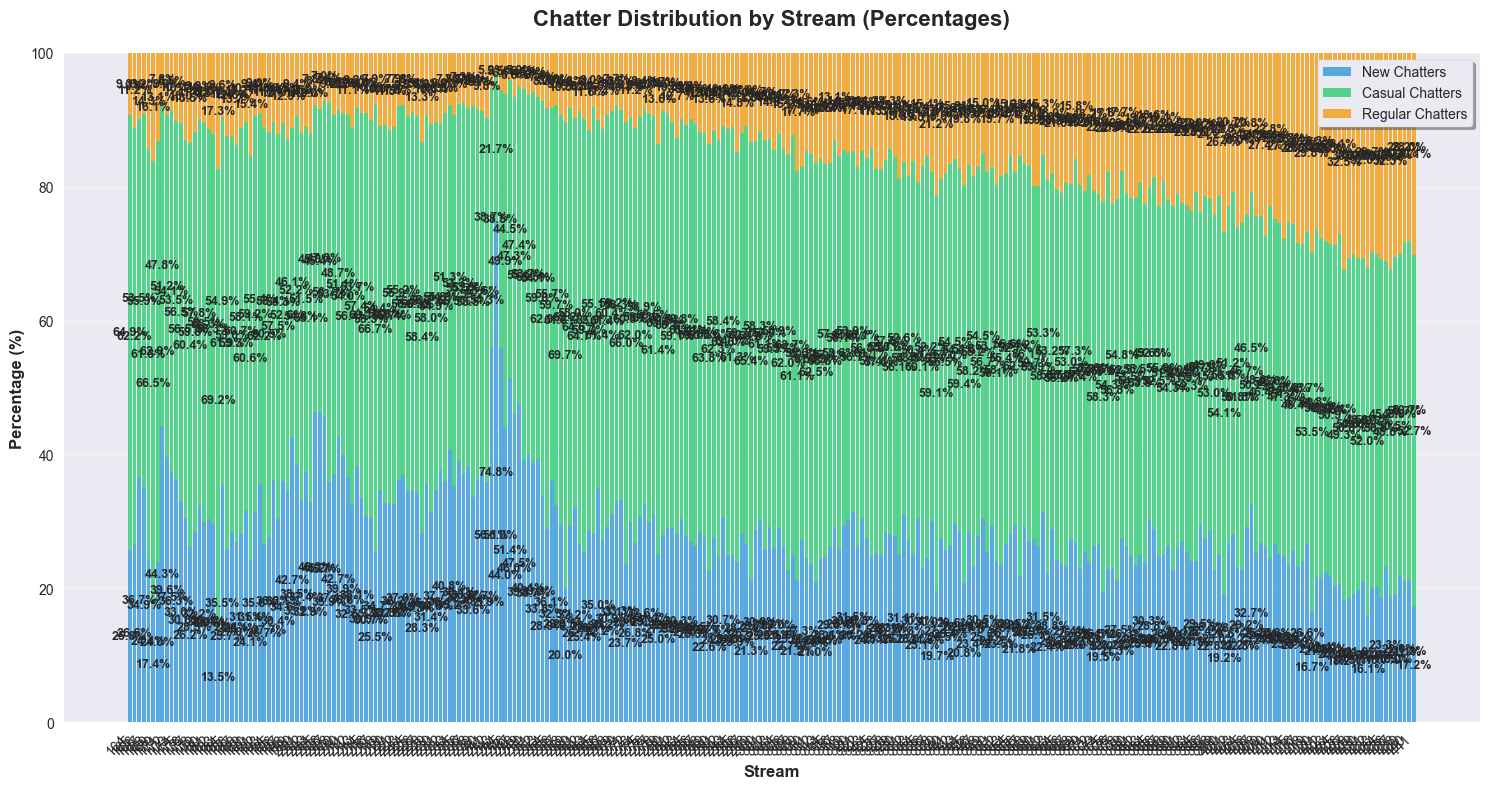

🥧 Creating pie chart...


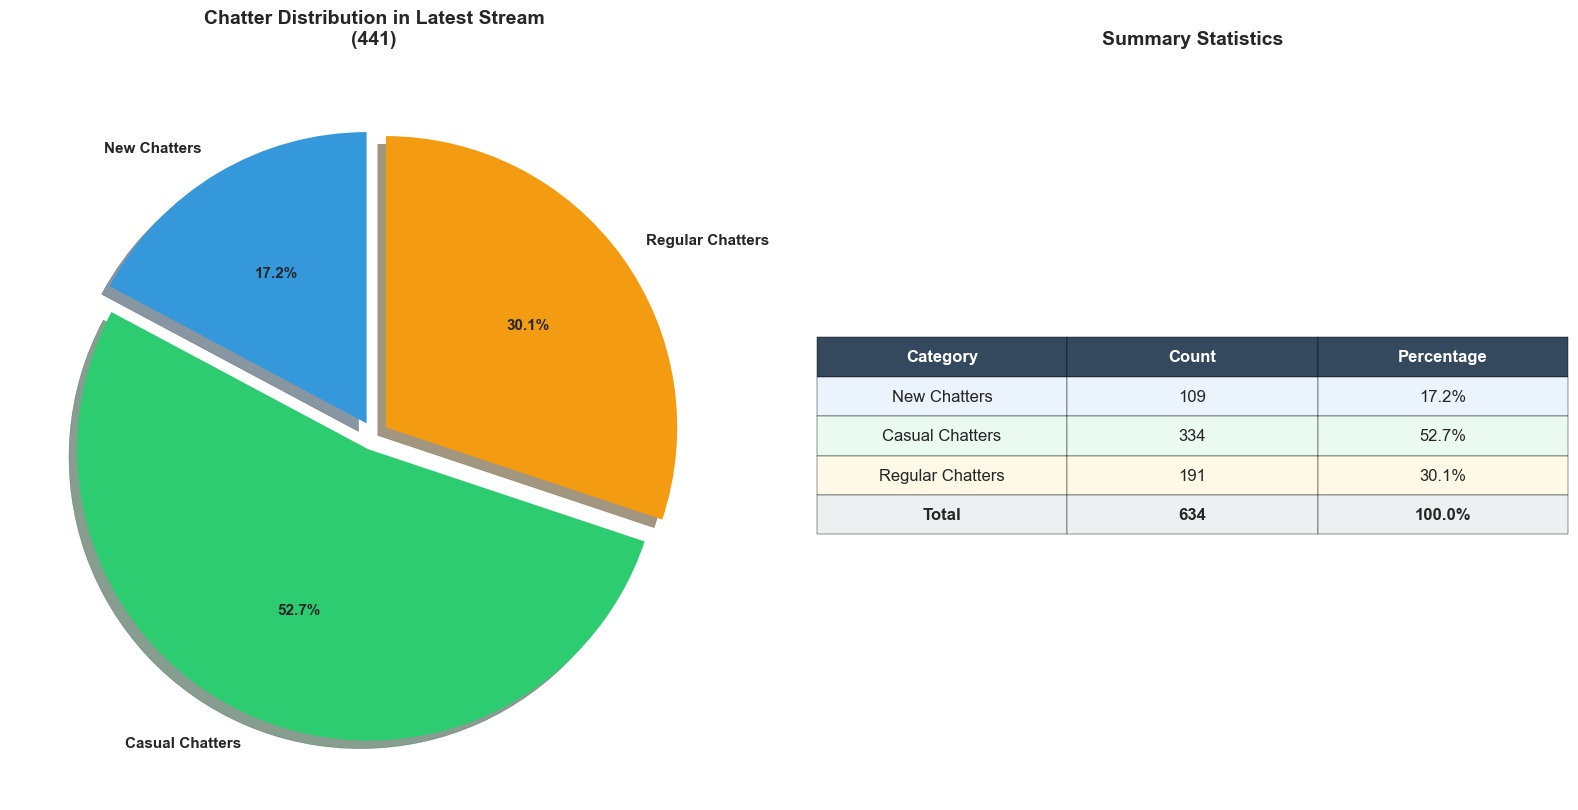


✅ Analysis complete! All visualizations have been generated.


In [9]:
# Set style for better looking plots
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

def analyze_chatters(data):
    if not pd.api.types.is_datetime64_any_dtype(data['date']):
        data['date'] = pd.to_datetime(data['date'])

    # User first appearance
    user_first_appearance = (
        data.groupby('user')
        .agg(first_date=('date', 'min'), first_stream=('stream', 'first'))
        .reset_index()
    )
    
    user_meta = user_first_appearance.set_index('user').to_dict(orient='index')

    # Filter after Nov 15, 2024
    start_date = pd.to_datetime('2024-11-15')

    # If your data is tz-aware, localize start_date to that tz
    if hasattr(data['date'].dtype, 'tz') and data['date'].dtype.tz is not None:
        start_date = start_date.tz_localize(data['date'].dtype.tz)

    filtered_data = data[data['date'] >= start_date].copy()

    # Group once by stream
    stream_analysis = []
    for stream_id, stream_data in filtered_data.groupby('stream'):
        unique_users = stream_data['user'].unique()
        stream_date = stream_data['date'].min()

        new_chatters, casual_chatters, regular_chatters = [], [], []

        for user in unique_users:
            first_info = user_meta.get(user)
            if first_info is None:
                continue

            if first_info['first_stream'] == stream_id:
                new_chatters.append(user)
            else:
                days_diff = (stream_date - first_info['first_date']).days
                if days_diff == 0:
                    new_chatters.append(user)
                elif days_diff < 180:
                    casual_chatters.append(user)
                else:
                    regular_chatters.append(user)


        total_users = len(new_chatters) + len(casual_chatters) + len(regular_chatters)
        stream_analysis.append({
            'stream': stream_id,
            'date': stream_date,
            'new_count': len(new_chatters),
            'casual_count': len(casual_chatters),
            'regular_count': len(regular_chatters),
            'new_percentage': (len(new_chatters) / total_users * 100) if total_users > 0 else 0,
            'casual_percentage': (len(casual_chatters) / total_users * 100) if total_users > 0 else 0,
            'regular_percentage': (len(regular_chatters) / total_users * 100) if total_users > 0 else 0,
            'total_users': total_users
        })

    return pd.DataFrame(stream_analysis)

def create_line_chart(stream_df):
    """
    Create line chart showing chatter counts over time
    """
    fig, ax = plt.subplots(figsize=(15, 8))
    
    # Plot lines
    ax.plot(range(len(stream_df)), stream_df['new_count'], 
            marker='o', linewidth=2.5, markersize=6, label='New Chatters', color='#3498db')
    ax.plot(range(len(stream_df)), stream_df['casual_count'], 
            marker='s', linewidth=2.5, markersize=6, label='Casual Chatters', color='#2ecc71')
    ax.plot(range(len(stream_df)), stream_df['regular_count'], 
            marker='^', linewidth=2.5, markersize=6, label='Regular Chatters', color='#f39c12')
    
    # Customize chart
    ax.set_xlabel('Stream', fontsize=12, fontweight='bold')
    ax.set_ylabel('Number of Chatters', fontsize=12, fontweight='bold')
    ax.set_title('Chatter Counts Over Time (from Nov 15, 2024)', fontsize=16, fontweight='bold', pad=20)
    
    # Set x-axis labels
    ax.set_xticks(range(len(stream_df)))
    ax.set_xticklabels(stream_df['stream'], rotation=45, ha='right')
    
    # Add grid and legend
    ax.grid(True, alpha=0.3)
    ax.legend(loc='upper left', frameon=True, fancybox=True, shadow=True)
    
    # Add annotations for max values
    for col, color in [('new_count', '#3498db'), ('casual_count', '#2ecc71'), ('regular_count', '#f39c12')]:
        max_idx = stream_df[col].idxmax()
        max_val = stream_df[col].max()
        ax.annotate(f'Max: {max_val}', 
                   xy=(max_idx, max_val), xytext=(10, 10),
                   textcoords='offset points', fontsize=9,
                   bbox=dict(boxstyle='round,pad=0.3', facecolor=color, alpha=0.7),
                   arrowprops=dict(arrowstyle='->', connectionstyle='arc3,rad=0'))
    
    plt.tight_layout()
    return fig

def create_stacked_bar_chart(stream_df):
    """
    Create stacked bar chart showing percentage distribution
    """
    fig, ax = plt.subplots(figsize=(15, 8))
    
    # Data for stacked bar
    streams = range(len(stream_df))
    new_pct = stream_df['new_percentage']
    casual_pct = stream_df['casual_percentage']
    regular_pct = stream_df['regular_percentage']
    
    # Create stacked bars
    width = 0.8
    ax.bar(streams, new_pct, width, label='New Chatters', color='#3498db', alpha=0.8)
    ax.bar(streams, casual_pct, width, bottom=new_pct, label='Casual Chatters', color='#2ecc71', alpha=0.8)
    ax.bar(streams, regular_pct, width, bottom=new_pct + casual_pct, label='Regular Chatters', color='#f39c12', alpha=0.8)
    
    # Customize chart
    ax.set_xlabel('Stream', fontsize=12, fontweight='bold')
    ax.set_ylabel('Percentage (%)', fontsize=12, fontweight='bold')
    ax.set_title('Chatter Distribution by Stream (Percentages)', fontsize=16, fontweight='bold', pad=20)
    ax.set_ylim(0, 100)
    
    # Set x-axis labels
    ax.set_xticks(streams)
    ax.set_xticklabels(stream_df['stream'], rotation=45, ha='right')
    
    # Add percentage labels on bars
    for i, (new, casual, regular) in enumerate(zip(new_pct, casual_pct, regular_pct)):
        if new > 5:  # Only show label if segment is large enough
            ax.text(i, new/2, f'{new:.1f}%', ha='center', va='center', fontweight='bold', fontsize=9)
        if casual > 5:
            ax.text(i, new + casual/2, f'{casual:.1f}%', ha='center', va='center', fontweight='bold', fontsize=9)
        if regular > 5:
            ax.text(i, new + casual + regular/2, f'{regular:.1f}%', ha='center', va='center', fontweight='bold', fontsize=9)
    
    ax.grid(True, alpha=0.3, axis='y')
    ax.legend(loc='upper right', frameon=True, fancybox=True, shadow=True)
    
    plt.tight_layout()
    return fig

def create_pie_chart(stream_df):
    """
    Create pie chart for the latest stream
    """
    if len(stream_df) == 0:
        print("No data available for pie chart")
        return None
    
    # Get data for last stream
    last_stream = stream_df.iloc[-1]
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8))
    
    # Pie chart data
    sizes = [last_stream['new_count'], last_stream['casual_count'], last_stream['regular_count']]
    labels = ['New Chatters', 'Casual Chatters', 'Regular Chatters']
    colors = ['#3498db', '#2ecc71', '#f39c12']
    explode = (0.05, 0.05, 0.05)  # explode slices slightly
    
    # Create pie chart
    wedges, texts, autotexts = ax1.pie(sizes, explode=explode, labels=labels, colors=colors,
                                      autopct='%1.1f%%', shadow=True, startangle=90,
                                      textprops={'fontsize': 11, 'fontweight': 'bold'})
    
    ax1.set_title(f'Chatter Distribution in Latest Stream\n({last_stream["stream"]})', 
                  fontsize=14, fontweight='bold', pad=20)
    
    # Summary statistics table
    ax2.axis('off')
    summary_data = [
        ['Category', 'Count', 'Percentage'],
        ['New Chatters', f"{last_stream['new_count']}", f"{last_stream['new_percentage']:.1f}%"],
        ['Casual Chatters', f"{last_stream['casual_count']}", f"{last_stream['casual_percentage']:.1f}%"],
        ['Regular Chatters', f"{last_stream['regular_count']}", f"{last_stream['regular_percentage']:.1f}%"],
        ['Total', f"{last_stream['total_users']}", "100.0%"]
    ]
    
    table = ax2.table(cellText=summary_data[1:], colLabels=summary_data[0],
                     cellLoc='center', loc='center', 
                     colColours=['#f0f0f0']*3)
    table.auto_set_font_size(False)
    table.set_fontsize(12)
    table.scale(1, 2)
    
    # Style the table
    for i in range(len(summary_data)):
        for j in range(3):
            cell = table[(i, j)]
            if i == 0:  # Header row
                cell.set_text_props(weight='bold')
                cell.set_facecolor('#34495e')
                cell.set_text_props(color='white')
            elif i == len(summary_data) - 1:  # Total row
                cell.set_text_props(weight='bold')
                cell.set_facecolor('#ecf0f1')
            else:
                cell.set_facecolor(['#ebf3fd', '#eafaf1', '#fef9e7'][i-1])
    
    ax2.set_title('Summary Statistics', fontsize=14, fontweight='bold', pad=20)
    
    plt.tight_layout()
    return fig


# Main execution
def main():
    """
    Main function to run the analysis
    """
    print("🚀 Starting Chatlog Analysis...")
    print("="*50)
    
    print(f"✅ Data loaded: {len(data)} messages from {data['user'].nunique()} unique users")
    print(f"📅 Date range: {data['date'].min()} to {data['date'].max()}")
    print(f"🎮 Total streams: {data['stream'].nunique()}")
    
    # Analyze the data
    print("\n🔍 Analyzing chatter categories...")
    stream_analysis = analyze_chatters(data)
    
    if len(stream_analysis) == 0:
        print("❌ No streams found from Nov 15, 2024 onwards")
        return
    
    print(f"✅ Analysis complete: {len(stream_analysis)} streams analyzed from Nov 15, 2024")
    
    # Display summary statistics
    print("\n📈 Summary Statistics:")
    print("-" * 30)
    total_new = stream_analysis['new_count'].sum()
    total_casual = stream_analysis['casual_count'].sum()
    total_regular = stream_analysis['regular_count'].sum()
    total_all = total_new + total_casual + total_regular
    
    print(f"Total New Chatters: {total_new}")
    print(f"Total Casual Chatters: {total_casual}")
    print(f"Total Regular Chatters: {total_regular}")
    print(f"Average per stream: {total_all / len(stream_analysis):.1f} unique chatters")
    
    # Create visualizations
    print("\n🎨 Creating visualizations...")
    
    # 1. Line Chart
    print("📈 Creating line chart...")
    fig1 = create_line_chart(stream_analysis)
    plt.show()
    
    # 2. Stacked Bar Chart
    print("📊 Creating stacked bar chart...")
    fig2 = create_stacked_bar_chart(stream_analysis)
    plt.show()
    
    # 3. Pie Chart
    print("🥧 Creating pie chart...")
    fig3 = create_pie_chart(stream_analysis)
    plt.show()
    
    print("\n✅ Analysis complete! All visualizations have been generated.")
    
    # Return the analysis data for further use
    return stream_analysis, data

# Run the analysis
if __name__ == "__main__":
    analysis_results, original_data = main()
